# Fine-tuning de un ViT para Food101

Este notebook muestra cómo realizar fine-tuning de un modelo Vision Transformer (ViT) preentrenado para clasificación de imágenes usando el dataset Food101.

## Objetivo
Adaptar un modelo ViT preentrenado (`google/vit-base-patch16-224-in21k`) a la tarea específica de clasificación de alimentos usando el dataset Food101, que contiene 101 categorías diferentes de comida.

## Flujo del proceso:
1. **Importación de librerías**: Cargar las dependencias necesarias
2. **Configuración del modelo**: Seleccionar el checkpoint del modelo preentrenado
3. **Carga del dataset**: Cargar y preparar el dataset Food101
4. **Preprocesamiento**: Definir transformaciones de imagen para entrenamiento y validación
5. **Configuración del modelo**: Cargar el modelo con las etiquetas del dataset
6. **Configuración del entrenamiento**: Definir hiperparámetros y argumentos de entrenamiento
7. **Entrenamiento**: Ejecutar el fine-tuning del modelo
8. **Evaluación**: Medir el rendimiento del modelo entrenado


## Paso 1: Importación de librerías

Importamos las librerías esenciales:
- `numpy`: Para operaciones numéricas
- `torch`: PyTorch para deep learning
- `transformers`: Librería de Hugging Face para modelos preentrenados
- `evaluate`: Para calcular métricas de evaluación


In [ ]:
import numpy as np; import torch; import transformers; import evaluate

## Paso 2: Configuración del modelo

Definimos el checkpoint del modelo preentrenado que vamos a usar. `google/vit-base-patch16-224-in21k` es un Vision Transformer base que fue preentrenado en ImageNet-21k (14 millones de imágenes, 21k clases). Este modelo será adaptado a nuestra tarea específica mediante fine-tuning.


In [ ]:
model_checkpoint = "google/vit-base-patch16-224-in21k"

## Paso 3: Carga del dataset Food101

Cargamos el dataset Food101 que contiene imágenes de 101 categorías diferentes de comida. Para hacer pruebas más rápidas, seleccionamos solo 5000 muestras del conjunto completo (que tiene 75,750 imágenes de entrenamiento). El dataset se baraja con una semilla aleatoria para garantizar reproducibilidad.


In [ ]:
from datasets import load_dataset
full_dataset = load_dataset("food101", split="train")
dataset = full_dataset.shuffle(seed=7).select(range(5000)); del full_dataset # mucho menos para pruebas

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00008.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

data/train-00001-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

data/train-00002-of-00008.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

data/train-00003-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

data/train-00004-of-00008.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

data/train-00005-of-00008.parquet:   0%|          | 0.00/470M [00:00<?, ?B/s]

data/train-00006-of-00008.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

data/train-00007-of-00008.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

data/validation-00000-of-00003.parquet:   0%|          | 0.00/423M [00:00<?, ?B/s]

data/validation-00001-of-00003.parquet:   0%|          | 0.00/413M [00:00<?, ?B/s]

data/validation-00002-of-00003.parquet:   0%|          | 0.00/426M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

## Paso 4: Visualización de una imagen de ejemplo

Mostramos una imagen del dataset para verificar que se cargó correctamente. El método `reduce(2)` reduce el tamaño de la imagen para visualización.


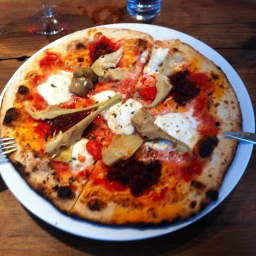

In [ ]:
dataset[0]['image'].reduce(2)

## Paso 5: Creación de diccionarios de etiquetas

Creamos dos diccionarios que mapean entre nombres de etiquetas e IDs numéricos:
- `label2id`: Mapea el nombre de la clase (string) a su ID numérico
- `id2label`: Mapea el ID numérico al nombre de la clase (string)

Estos diccionarios son necesarios para que el modelo pueda trabajar con las etiquetas del dataset Food101. Verificamos que la primera etiqueta (ID 0) sea 'apple_pie'.


In [ ]:
labels = dataset.features["label"].names; label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
 label2id[label] = i; id2label[i] = label
id2label[0]

'apple_pie'

## Paso 6: Carga del procesador de imágenes

Cargamos el procesador de imágenes (`AutoImageProcessor`) asociado al modelo ViT. Este procesador contiene la configuración necesaria para preprocesar las imágenes (normalización, redimensionamiento, etc.) de acuerdo con cómo el modelo fue preentrenado. Esto es crucial para mantener la consistencia con el preentrenamiento.


In [ ]:
from transformers import AutoImageProcessor
image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

## Paso 7: Definición de transformaciones de imagen

Definimos dos conjuntos de transformaciones:

**Para entrenamiento (`train_transforms`):**
- `RandomResizedCrop`: Recorte aleatorio y redimensionamiento (data augmentation)
- `RandomHorizontalFlip`: Volteo horizontal aleatorio (data augmentation)
- `ToTensor`: Conversión a tensor de PyTorch
- `Normalize`: Normalización usando la media y desviación estándar del modelo preentrenado

**Para validación (`val_transforms`):**
- `Resize`: Redimensionamiento al tamaño esperado (224x224)
- `CenterCrop`: Recorte centrado
- `ToTensor`: Conversión a tensor
- `Normalize`: Normalización

Luego dividimos el dataset en entrenamiento (90%) y validación (10%), y aplicamos las transformaciones correspondientes a cada partición.


In [ ]:
from torchvision.transforms import (CenterCrop, Compose, Normalize, RandomHorizontalFlip, RandomResizedCrop,
 Resize, ToTensor)
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
train_transforms = Compose([RandomResizedCrop(image_processor.size["height"]),
 RandomHorizontalFlip(), ToTensor(), normalize])
val_transforms = Compose([Resize(image_processor.size["height"]), CenterCrop(image_processor.size["height"]),
 ToTensor(), normalize])
def preprocess_train(example_batch):
 """Apply train_transforms across a batch."""
 example_batch["pixel_values"] = [train_transforms(image.convert("RGB")) for image in example_batch["image"]]
 return example_batch
def preprocess_val(example_batch):
 """Apply val_transforms across a batch."""
 example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
 return example_batch
splits = dataset.train_test_split(test_size=0.1)
train_ds = splits["train"]; val_ds = splits["test"]
train_ds.set_transform(preprocess_train); val_ds.set_transform(preprocess_val)

## Paso 8: Verificación del preprocesamiento

Verificamos que el preprocesamiento se aplicó correctamente. El dataset ahora debe contener las claves: 'image', 'label', y 'pixel_values' (los valores de píxeles preprocesados).


In [ ]:
train_ds[0].keys()

dict_keys(['image', 'label', 'pixel_values'])

## Paso 9: Carga del modelo para clasificación de imágenes

Cargamos el modelo ViT preentrenado y lo adaptamos para clasificación de imágenes usando `AutoModelForImageClassification`. El modelo se inicializa con:
- Los pesos preentrenados del checkpoint
- Una nueva capa clasificadora adaptada a las 101 clases de Food101
- Los diccionarios `label2id` e `id2label` para mapear las etiquetas

Nota: La capa clasificadora (`classifier.weight` y `classifier.bias`) se inicializa aleatoriamente ya que es nueva para esta tarea específica.


In [ ]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
model = AutoModelForImageClassification.from_pretrained(model_checkpoint, label2id=label2id, id2label=id2label)
print(str(model)[:1400]+" ...")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

## Paso 10: Configuración de los argumentos de entrenamiento

Definimos los hiperparámetros y configuración del entrenamiento usando `TrainingArguments`:

- **Directorio de salida**: Donde se guardarán los checkpoints
- **Estrategia de evaluación**: Evaluar al final de cada época
- **Estrategia de guardado**: Guardar checkpoint al final de cada época
- **Learning rate**: 5e-5 (tasa de aprendizaje típica para fine-tuning)
- **Batch size**: 32 muestras por dispositivo
- **Gradient accumulation**: 4 pasos (efectivamente batch size = 32 × 4 = 128)
- **Épocas**: 5 épocas de entrenamiento
- **Warmup ratio**: 10% de los pasos para calentamiento del learning rate
- **Cargar mejor modelo**: Cargar automáticamente el mejor modelo basado en accuracy


In [ ]:
model_name = model_checkpoint.split("/")[-1]; batch_size = 32
args = TrainingArguments(
 f"{model_name}-finetuned-food101",
 remove_unused_columns=False,
 eval_strategy = "epoch",
 save_strategy = "epoch",
 learning_rate=5e-5,
 per_device_train_batch_size=batch_size,
 gradient_accumulation_steps=4,
 per_device_eval_batch_size=batch_size,
 num_train_epochs=5,
 warmup_ratio=0.1,
 logging_steps=10,
 load_best_model_at_end=True,
 metric_for_best_model="accuracy",
 push_to_hub=False)

## Paso 11: Definición de la función de métricas

Cargamos la métrica de accuracy y definimos una función `compute_metrics` que:
1. Toma las predicciones del modelo (logits) y las etiquetas verdaderas
2. Convierte los logits a predicciones de clase usando `argmax`
3. Calcula la accuracy comparando predicciones con etiquetas verdaderas

Esta función se llamará automáticamente durante la evaluación.


In [ ]:
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
 """Computes accuracy on a batch of predictions"""
 predictions = np.argmax(eval_pred.predictions, axis=1)
 return metric.compute(predictions=predictions, references=eval_pred.label_ids)

## Paso 12: Función de collate para batches

Definimos una función `collate_fn` que agrupa múltiples ejemplos en un batch:
- Apila los `pixel_values` de todas las imágenes en un tensor
- Convierte las etiquetas a un tensor de PyTorch
- Retorna un diccionario con 'pixel_values' y 'labels'

Esta función es necesaria porque el Trainer necesita saber cómo combinar múltiples ejemplos en un batch.


In [ ]:
def collate_fn(examples):
 pixel_values = torch.stack([example["pixel_values"] for example in examples])
 labels = torch.tensor([example["label"] for example in examples])
 return {"pixel_values": pixel_values, "labels": labels}

## Paso 13: Inicialización del Trainer

Creamos una instancia del `Trainer` que manejará todo el ciclo de entrenamiento y evaluación. El Trainer recibe:
- El modelo a entrenar
- Los argumentos de entrenamiento
- Los datasets de entrenamiento y validación
- El procesador de imágenes
- La función de métricas
- La función de collate

El Trainer automatiza todo el proceso: forward pass, cálculo de pérdida, backward pass, actualización de pesos, logging, etc.


In [ ]:
trainer = Trainer(
 model,
 args,
 train_dataset=train_ds,
 eval_dataset=val_ds,
 processing_class=image_processor,
 compute_metrics=compute_metrics,
 data_collator=collate_fn)

## Paso 14: Entrenamiento del modelo

Ejecutamos el entrenamiento del modelo. El Trainer realizará:
1. Forward pass en cada batch
2. Cálculo de la pérdida (cross-entropy)
3. Backward pass para calcular gradientes
4. Actualización de pesos usando el optimizador
5. Evaluación al final de cada época
6. Guardado del mejor modelo basado en accuracy

Este proceso puede tomar varios minutos dependiendo del hardware disponible.


In [ ]:
train_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,4.520400,4.425988,0.242000
2,4.247500,4.201699,0.498000
3,4.068000,4.026145,0.540000
4,3.890600,3.921212,0.572000
5,3.816000,3.884542,0.580000


## Paso 15: Visualización de métricas de entrenamiento

Mostramos las métricas finales del entrenamiento, incluyendo:
- Número de épocas completadas
- Pérdida promedio de entrenamiento
- Tiempo total de entrenamiento
- Velocidad de procesamiento (muestras/segundo)


In [ ]:
trainer.log_metrics("train", train_results.metrics)

***** train metrics *****
  epoch                    =          5.0
  total_flos               = 1625266713GF
  train_loss               =       4.1407
  train_runtime            =   0:16:49.69
  train_samples_per_second =       22.284
  train_steps_per_second   =        0.178


## Paso 16: Evaluación final en el conjunto de validación

Realizamos una evaluación final en el conjunto de validación para obtener las métricas finales del modelo:
- **Accuracy**: Porcentaje de imágenes clasificadas correctamente
- **Loss**: Pérdida promedio en el conjunto de validación
- **Tiempo de evaluación**: Cuánto tardó la evaluación

Estas métricas nos indican qué tan bien generaliza el modelo a datos no vistos durante el entrenamiento.


In [ ]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        5.0
  eval_accuracy           =       0.58
  eval_loss               =     3.8845
  eval_runtime            = 0:00:08.91
  eval_samples_per_second =     56.082
  eval_steps_per_second   =      1.795


---

# Ejercicio: Fine-tuning de un ViT para CIFAR10

En esta segunda parte, aplicamos el mismo proceso de fine-tuning pero ahora con el dataset CIFAR10, que contiene 10 clases de objetos comunes (aviones, automóviles, pájaros, gatos, ciervos, perros, ranas, caballos, barcos y camiones).

## Objetivo del ejercicio
Completar el experimento de fine-tuning para obtener la precisión en el conjunto de test de CIFAR10.

El proceso es similar al anterior, pero adaptado a las características específicas de CIFAR10 (10 clases en lugar de 101, imágenes de 32x32 en lugar de tamaños variables).


## Paso 1: Importación de librerías

Importamos las mismas librerías necesarias para el ejercicio con CIFAR10.


In [ ]:
import numpy as np; import torch; import transformers; import evaluate

## Paso 2: Configuración del modelo

Usamos el mismo modelo preentrenado ViT que en el ejemplo anterior.


In [ ]:
model_checkpoint = "google/vit-base-patch16-224-in21k"

## Paso 3: Carga del dataset CIFAR10

Cargamos el dataset CIFAR10 que contiene:
- **Conjunto de entrenamiento**: 50,000 imágenes (usamos todas para el ejercicio)
- **Conjunto de test**: 10,000 imágenes

CIFAR10 tiene 10 clases: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. Las imágenes son de 32x32 píxeles.


In [ ]:
from datasets import load_dataset
train_ds, test_ds = load_dataset('cifar10', split=['train[:50000]', 'test[:10000]']) # mucho menos para pruebas

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

## Paso 4: Inspección del dataset

Verificamos la estructura del dataset para confirmar que se cargó correctamente. El dataset debe tener las características 'img' (imagen) y 'label' (etiqueta numérica).


In [ ]:
train_ds

Dataset({
    features: ['img', 'label'],
    num_rows: 50000
})

## Paso 5: Verificación de las características del dataset

Inspeccionamos las características del dataset para ver los tipos de datos y los nombres de las clases.


In [ ]:
train_ds.features

{'img': Image(mode=None, decode=True),
 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])}

## Paso 6: Visualización de imágenes de ejemplo

Visualizamos algunas imágenes del dataset para familiarizarnos con los datos. CIFAR10 contiene imágenes pequeñas (32x32) de objetos comunes.


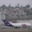

In [ ]:
train_ds[0]['img']

## Paso 7: Verificación de etiquetas

Verificamos las etiquetas numéricas asociadas a las imágenes. En CIFAR10, las etiquetas son números del 0 al 9, cada uno correspondiente a una clase específica.


In [ ]:
train_ds[0]['label']

0

## Paso 8: Creación de diccionarios de etiquetas para CIFAR10

Creamos los diccionarios `id2label` y `label2id` para mapear entre IDs numéricos y nombres de clases de CIFAR10. Esto es necesario para que el modelo pueda trabajar correctamente con las 10 clases del dataset.


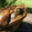

In [ ]:
train_ds[1]['img']

## Paso 9: Carga del procesador de imágenes

Cargamos el mismo procesador de imágenes del modelo ViT. Este procesador redimensionará las imágenes de CIFAR10 (32x32) al tamaño esperado por el modelo (224x224).


In [ ]:
train_ds[1]['label']

6

## Paso 10: Definición de transformaciones para CIFAR10

Aplicamos las mismas transformaciones que en el ejemplo anterior, pero adaptadas a CIFAR10:
- **Entrenamiento**: RandomResizedCrop, RandomHorizontalFlip, ToTensor, Normalize
- **Test**: Resize, CenterCrop, ToTensor, Normalize

Nota: En CIFAR10, la columna de imagen se llama 'img' en lugar de 'image', por lo que ajustamos las funciones de preprocesamiento en consecuencia.


In [ ]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
str(id2label)

"{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}"

## Paso 11: Carga del modelo para CIFAR10

Cargamos el modelo ViT adaptado para las 10 clases de CIFAR10. La capa clasificadora se inicializará aleatoriamente para estas 10 clases específicas.


In [ ]:
from transformers import AutoImageProcessor
image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


## Paso 12: Configuración de argumentos de entrenamiento para CIFAR10

Configuramos los argumentos de entrenamiento similares al ejemplo anterior, pero con algunas diferencias:
- **Épocas**: 3 épocas (CIFAR10 es más simple que Food101, necesita menos entrenamiento)
- **Directorio de salida**: Cambiado a 'vit-base-patch16-224-in21k-finetuned-cifar10'

El resto de hiperparámetros se mantienen similares para mantener consistencia.


In [ ]:
from torchvision.transforms import (CenterCrop, Compose, Normalize, RandomHorizontalFlip, RandomResizedCrop,
 Resize, ToTensor)
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
train_transforms = Compose([RandomResizedCrop(image_processor.size["height"]),
 RandomHorizontalFlip(), ToTensor(), normalize])
val_transforms = Compose([Resize(image_processor.size["height"]), CenterCrop(image_processor.size["height"]),
 ToTensor(), normalize])
def preprocess_train(example_batch):
 """Apply train_transforms across a batch."""
 example_batch["pixel_values"] = [train_transforms(image.convert("RGB")) for image in example_batch["img"]]
 return example_batch
def preprocess_val(example_batch):
 """Apply val_transforms across a batch."""
 example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["img"]]
 return example_batch
train_ds.set_transform(preprocess_train)
test_ds.set_transform(preprocess_val)

## Paso 13: Definición de la función de métricas

Usamos la misma función de métricas que en el ejemplo anterior para calcular la accuracy durante la evaluación.


In [ ]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
model = AutoModelForImageClassification.from_pretrained(model_checkpoint, label2id=label2id, id2label=id2label)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Paso 14: Función de collate

Usamos la misma función de collate para agrupar ejemplos en batches durante el entrenamiento.


In [ ]:
model_name = model_checkpoint.split("/")[-1]; batch_size = 32
args = TrainingArguments(
 f"{model_name}-finetuned-cifar10",
 remove_unused_columns=False,
 eval_strategy = "epoch",
 save_strategy = "epoch",
 learning_rate=5e-5,
 per_device_train_batch_size=batch_size,
 gradient_accumulation_steps=4,
 per_device_eval_batch_size=batch_size,
 num_train_epochs=3,
 warmup_ratio=0.1,
 logging_steps=10,
 load_best_model_at_end=True,
 metric_for_best_model="accuracy",
 push_to_hub=False)

## Paso 15: Inicialización del Trainer para CIFAR10

Creamos el Trainer con el modelo, datasets y configuraciones para CIFAR10. En este caso, usamos el conjunto de test como conjunto de evaluación (en lugar de una partición de validación separada).


In [ ]:
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
 """Computes accuracy on a batch of predictions"""
 predictions = np.argmax(eval_pred.predictions, axis=1)
 return metric.compute(predictions=predictions, references=eval_pred.label_ids)

## Paso 16: Entrenamiento del modelo en CIFAR10

Ejecutamos el entrenamiento del modelo. El Trainer realizará el fine-tuning del modelo ViT preentrenado adaptándolo a las 10 clases de CIFAR10. Durante el entrenamiento, el modelo aprenderá a distinguir entre aviones, automóviles, pájaros, gatos, ciervos, perros, ranas, caballos, barcos y camiones.


In [ ]:
def collate_fn(examples):
 pixel_values = torch.stack([example["pixel_values"] for example in examples])
 labels = torch.tensor([example["label"] for example in examples])
 return {"pixel_values": pixel_values, "labels": labels}

## Paso 17: Visualización de métricas de entrenamiento

Mostramos las métricas finales del entrenamiento en CIFAR10, incluyendo la pérdida promedio y el tiempo total de entrenamiento.


In [ ]:
trainer = Trainer(
 model,
 args,
 train_dataset=train_ds,
 eval_dataset=test_ds,
 processing_class=image_processor,
 compute_metrics=compute_metrics,
 data_collator=collate_fn)

## Paso 18: Evaluación final en el conjunto de test

Realizamos la evaluación final en el conjunto de test de CIFAR10 para obtener la precisión final del modelo. Esta es la métrica principal del ejercicio: la accuracy en el conjunto de test nos indica qué tan bien el modelo generaliza a datos completamente nuevos.

**Resultado esperado**: Con un modelo bien entrenado, deberíamos obtener una accuracy superior al 98% en CIFAR10, ya que es una tarea relativamente simple y el modelo ViT preentrenado tiene una capacidad muy alta.


In [ ]:
train_results = trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 1


wandb: You chose 'Create a W&B account'
wandb: Create an account here: https://wandb.ai/authorize?signup=true&ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nadiva1243 (nadiva1243-universitat-polit-cnica-de-val-ncia) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.363000,0.203214,0.978700
2,0.308700,0.121813,0.983800
3,0.222400,0.099499,0.987000


In [ ]:
trainer.log_metrics("train", train_results.metrics)

***** train metrics *****
  epoch                    =           3.0
  total_flos               = 10826282096GF
  train_loss               =        0.5029
  train_runtime            =    1:33:23.20
  train_samples_per_second =         26.77
  train_steps_per_second   =         0.209


In [ ]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =      0.987
  eval_loss               =     0.0995
  eval_runtime            = 0:02:18.53
  eval_samples_per_second =     72.182
  eval_steps_per_second   =      2.259
